Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
import re

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [2]:
from pymystem3 import Mystem
import os, json
mystem = Mystem()

In [3]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    tokens = [mystem.lemmatize(token)[0] for token in tokens if token and mystem.lemmatize(token)[0] != '—\n']
    return tokens

In [4]:
wiki = open('wiki_data.txt').read().split('\n')
vocab = Counter()

for text in wiki:
  vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [5]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

Skip Gram

In [6]:
X = []
y = []

window = 10
for sent in sentences[:1000]:
    for i in range(len(sent)-1):
        word = sent[i] # target
        context = sent[max(0, i-window):i] + sent[i+1:i+window]  # context (слова до и после целевого)

        for context_word in context:
            X.append(word)
            y.append(context_word)

In [7]:
X[1], y[1]

(4857, 4491)

In [8]:
len(X), len(y)

(4302517, 4302517)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [10]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=len(word2id),
                                    input_length=1,
                                    output_dim=150))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(len(word2id),
                                activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy')

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 150)            1836900   
                                                                 
 flatten (Flatten)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 12246)             1849146   
                                                                 
Total params: 3686046 (14.06 MB)
Trainable params: 3686046 (14.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Обучаем модель.

In [12]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=5)

Epoch 1/5
4088/4088 [==============================] - 57s 13ms/step - loss: 7.3259 - val_loss: 7.1226
Epoch 2/5
4088/4088 [==============================] - 41s 10ms/step - loss: 7.0135 - val_loss: 6.9688
Epoch 3/5
4088/4088 [==============================] - 40s 10ms/step - loss: 6.8659 - val_loss: 6.8921
Epoch 4/5
4088/4088 [==============================] - 40s 10ms/step - loss: 6.7643 - val_loss: 6.8601
Epoch 5/5
4088/4088 [==============================] - 41s 10ms/step - loss: 6.6909 - val_loss: 6.8543


dict_keys(['loss', 'val_loss'])


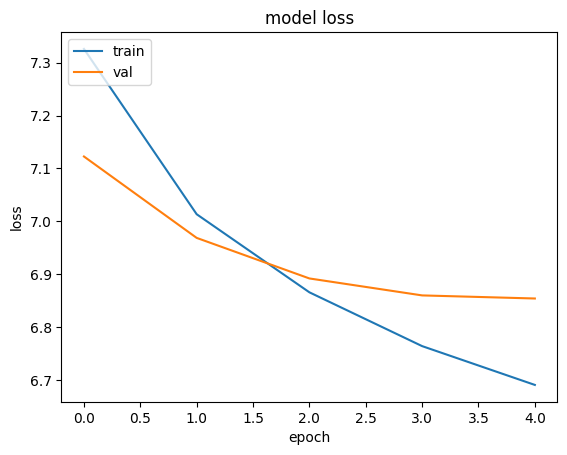

In [13]:
print(model.history.history.keys())
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
model.layers

In [15]:
model.layers[0].get_weights()[0].shape

(12246, 150)

In [16]:
model.layers[2].get_weights()[0].shape

(150, 12246)

In [17]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T

embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

embeddings.shape

(12246, 150)

In [18]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [19]:
most_similar('машина', embeddings)

['машина',
 'автомобиль',
 'колесо',
 'lotus',
 'расстреливать',
 'убийца',
 'привод',
 'автомат',
 'пистолет',
 'стрелять']

In [20]:
most_similar('цветок', embeddings)

['цветок',
 'фиолетовый',
 'лепесток',
 'коробочка',
 'удлинять',
 'чашечка',
 'цветоножка',
 'черешок',
 'декоративный',
 'крепкий']

CBOW

In [21]:
X = []
y = []

window = 10
for sent in sentences[:10000]:
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-window):i] + sent[i+1:i+window]

        X.append(context)
        y.append(word)

In [22]:
X[:10]

[[10694, 4491, 2558, 4068, 4127, 3512, 4857, 10694, 11258],
 [4857, 4491, 2558, 4068, 4127, 3512, 4857, 10694, 11258, 4068],
 [4857, 10694, 2558, 4068, 4127, 3512, 4857, 10694, 11258, 4068, 7464],
 [4857, 10694, 4491, 4068, 4127, 3512, 4857, 10694, 11258, 4068, 7464, 10246],
 [4857,
  10694,
  4491,
  2558,
  4127,
  3512,
  4857,
  10694,
  11258,
  4068,
  7464,
  10246,
  2558],
 [4857,
  10694,
  4491,
  2558,
  4068,
  3512,
  4857,
  10694,
  11258,
  4068,
  7464,
  10246,
  2558,
  5842],
 [4857,
  10694,
  4491,
  2558,
  4068,
  4127,
  4857,
  10694,
  11258,
  4068,
  7464,
  10246,
  2558,
  5842,
  4068],
 [4857,
  10694,
  4491,
  2558,
  4068,
  4127,
  3512,
  10694,
  11258,
  4068,
  7464,
  10246,
  2558,
  5842,
  4068,
  908],
 [4857,
  10694,
  4491,
  2558,
  4068,
  4127,
  3512,
  4857,
  11258,
  4068,
  7464,
  10246,
  2558,
  5842,
  4068,
  908,
  10511],
 [4857,
  10694,
  4491,
  2558,
  4068,
  4127,
  3512,
  4857,
  10694,
  4068,
  7464,
  10246,
  

In [23]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=10, padding='post')
y = np.array(y)

In [24]:
# контексты после паддинга
X

array([[10694,  4491,  2558, ..., 10694, 11258,     0],
       [ 4857,  4491,  2558, ..., 10694, 11258,  4068],
       [10694,  2558,  4068, ..., 11258,  4068,  7464],
       ...,
       [ 1643,  6071,  7054, ...,   586,  8713, 11599],
       [ 1643,  6071,  7054, ...,  1512,  8713, 11599],
       [ 1643,  6071,  7054, ...,  1512,   586, 11599]], dtype=int32)

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=len(word2id),
                                    input_length=10,
                                    output_dim=150))

model.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1)))

model.add(tf.keras.layers.Dense(len(word2id), activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

In [27]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 150)           1836900   
                                                                 
 lambda_1 (Lambda)           (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 12246)             1849146   
                                                                 
Total params: 3686046 (14.06 MB)
Trainable params: 3686046 (14.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Обучаем модель.

In [28]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=5)

Epoch 1/5
2013/2013 [==============================] - 55s 27ms/step - loss: 6.7578 - val_loss: 6.2395
Epoch 2/5
2013/2013 [==============================] - 24s 12ms/step - loss: 5.9647 - val_loss: 5.9389
Epoch 3/5
2013/2013 [==============================] - 21s 11ms/step - loss: 5.6306 - val_loss: 5.8244
Epoch 4/5
2013/2013 [==============================] - 22s 11ms/step - loss: 5.4099 - val_loss: 5.7832
Epoch 5/5
2013/2013 [==============================] - 22s 11ms/step - loss: 5.2457 - val_loss: 5.7814


dict_keys(['loss', 'val_loss'])


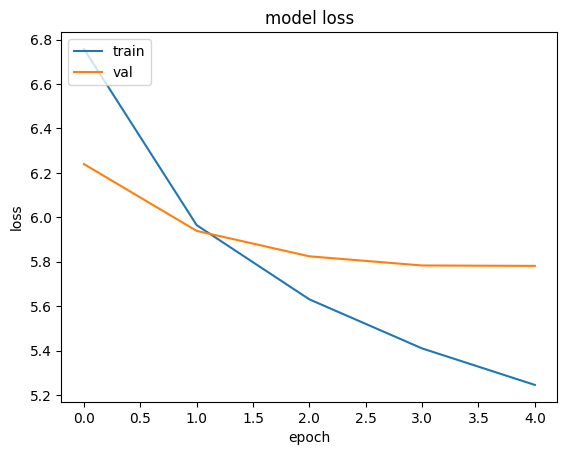

In [29]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T

embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

embeddings.shape

(12246, 150)

In [31]:
most_similar('машина', embeddings)

['машина',
 'автомобиль',
 'врезаться',
 'двигатель',
 'кабина',
 'взрываться',
 'мотор',
 'гоночный',
 'мощность',
 'паровой']

In [32]:
most_similar('цветок', embeddings)

['цветок',
 'соцветие',
 'лепесток',
 'фиолетовый',
 'розовый',
 'черешок',
 'цвести',
 'цветков',
 'тычинка',
 'цветение']

CBOW выдаёт результаты лучше, чем Skip Gram.

Добавляем негативное семплирование

In [33]:
vocab_size = len(id2word)

In [34]:
def gen_batches_sg(sentences, window = 10, batch_size=1000):

    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [35]:
def gen_batches_cbow(sentences, window = 5, batch_size=1000):

    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [36]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Обучаем модель.

In [37]:
model.fit(gen_batches_sg(sentences[:19000], window=5),
          validation_data=gen_batches_sg(sentences[19000:],  window=10),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=5)

Epoch 1/5
10000/10000 [==============================] - 103s 10ms/step - loss: 0.4265 - accuracy: 0.8128 - val_loss: 0.4709 - val_accuracy: 0.7962
Epoch 2/5
10000/10000 [==============================] - 80s 8ms/step - loss: 0.3893 - accuracy: 0.8330 - val_loss: 0.4446 - val_accuracy: 0.8111
Epoch 3/5
10000/10000 [==============================] - 74s 7ms/step - loss: 0.3792 - accuracy: 0.8377 - val_loss: 0.4042 - val_accuracy: 0.8330
Epoch 4/5
10000/10000 [==============================] - 69s 7ms/step - loss: 0.3690 - accuracy: 0.8419 - val_loss: 0.3908 - val_accuracy: 0.8323
Epoch 5/5
10000/10000 [==============================] - 72s 7ms/step - loss: 0.3571 - accuracy: 0.8468 - val_loss: 0.3858 - val_accuracy: 0.8326


In [38]:
embeddings = model.layers[2].get_weights()[0]

In [39]:
most_similar('машина', embeddings)

['машина',
 'грузовик',
 'автомобиль',
 'кабина',
 'паровоз',
 'мотоцикл',
 'шасси',
 'снаряд',
 'двигатель',
 'бронированный']

In [40]:
most_similar('цветок', embeddings)

['цветок',
 'темно-коричневый',
 'пурпурный',
 'зеленоватый',
 'округлый',
 'беловатый',
 'желтоватый',
 'надкрылья',
 'волосок',
 'лепесток']

In [41]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Обучаем модель.

In [42]:
model.fit(gen_batches_cbow(sentences[:19000], window=5),
          validation_data=gen_batches_cbow(sentences[19000:],  window=10),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=5)

Epoch 1/5
5000/5000 [==============================] - 119s 24ms/step - loss: 0.3695 - accuracy: 0.8417 - val_loss: 0.4259 - val_accuracy: 0.8617
Epoch 2/5
5000/5000 [==============================] - 53s 11ms/step - loss: 0.2822 - accuracy: 0.8841 - val_loss: 0.3787 - val_accuracy: 0.8831
Epoch 3/5
5000/5000 [==============================] - 47s 9ms/step - loss: 0.2365 - accuracy: 0.9034 - val_loss: 0.3856 - val_accuracy: 0.8829
Epoch 4/5
5000/5000 [==============================] - 47s 9ms/step - loss: 0.2118 - accuracy: 0.9142 - val_loss: 0.3589 - val_accuracy: 0.8954
Epoch 5/5
5000/5000 [==============================] - 47s 9ms/step - loss: 0.1900 - accuracy: 0.9240 - val_loss: 0.4772 - val_accuracy: 0.8796


In [43]:
embeddings = model.layers[2].get_weights()[0]

In [44]:
most_similar('машина', embeddings)

['машина',
 'автомобиль',
 'бомба',
 'самолет',
 'грузовик',
 'вагон',
 'шасси',
 'двигатель',
 'снаряд',
 'конструкция']

In [45]:
most_similar('цветок', embeddings)

['цветок',
 'плод',
 'цвет',
 'листва',
 'продолговатый',
 'волосок',
 'соцветие',
 'яблоко',
 'яйцевидный',
 'темно-коричневый']

С подключением негативного семплирования оба подхода работают лучше, но на мой взгляд Skip Gram немного точнее подбирает слова.

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [46]:
!pip install gensim

In [47]:
import gensim

In [48]:
texts = [preprocess(text) for text in wiki]

In [49]:
w2v = gensim.models.Word2Vec(texts,
                             cbow_mean=0,
                             ns_exponent=0.74,
                             sample=2e-5,
                             vector_size=150,
                             min_count=20,
                             max_vocab_size=8000,
                             window=10,
                             epochs=5,
                             sg=1,
                             negative=13)

In [50]:
w2v.wv.most_similar('машина')

[('автомобиль', 0.6943683624267578),
 ('двигатель', 0.6913053393363953),
 ('шасси', 0.6681115627288818),
 ('мощность', 0.6668919920921326),
 ('водитель', 0.6268988251686096),
 ('модификация', 0.6237474083900452),
 ('шина', 0.6230807304382324),
 ('модель', 0.6196593642234802),
 ('конструктор', 0.6029698252677917),
 ('авария', 0.5898498296737671)]

In [51]:
w2v.wv.most_similar('цветок')

[('плод', 0.7569547295570374),
 ('цвет', 0.7102493047714233),
 ('растение', 0.7037890553474426),
 ('см', 0.7022918462753296),
 ('ширина', 0.7011943459510803),
 ('округлый', 0.6987351775169373),
 ('тонкий', 0.6765201687812805),
 ('семя', 0.6725724935531616),
 ('желтый', 0.6634162068367004),
 ('волосок', 0.6630700826644897)]

In [52]:
ft = gensim.models.FastText(texts,
                             cbow_mean=0,
                             ns_exponent=0.74,
                             sample=2e-5,
                             vector_size=150,
                             min_count=20,
                             max_vocab_size=8000,
                             window=10,
                             epochs=5,
                             sg=0,
                             negative=13)

In [53]:
ft.wv.most_similar('машина')

[('автомашина', 0.8678464293479919),
 ('бронемашина', 0.8592280149459839),
 ('гидромашина', 0.8373979330062866),
 ('машинка', 0.8332700133323669),
 ('ашина', 0.8186041116714478),
 ('мачта', 0.7931103110313416),
 ('локомобиль', 0.7740293145179749),
 ('минейка', 0.7733217477798462),
 ('шина', 0.7707192897796631),
 ('бронеавтомобиль', 0.7630087733268738)]

In [54]:
ft.wv.most_similar('цветок')

[('цветоножка', 0.9276681542396545),
 ('цветонос', 0.9056914448738098),
 ('цвет', 0.8999495506286621),
 ('цветоложе', 0.8913561105728149),
 ('расцветка', 0.8507542610168457),
 ('веточка', 0.8370758295059204),
 ('светло-желтый', 0.827544629573822),
 ('крышечка', 0.8233448266983032),
 ('щелчок', 0.8232196569442749),
 ('светло-коричневый', 0.8155714869499207)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019).
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)